 # BLSTM vs Transformers
 This script builds and runs two classification models. One mdoel is built with
 BLSTM layers while the other uses Transformer layers. The script also compares
 the two models in both performance and time.

In [1]:
import io
import sys
import time
from collections import Counter
from typing import Any

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf
import tensorflow.keras.layers as layers
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras as keras
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import plot_model
from tensorflow.python.keras import callbacks
from tensorflow.python.keras.engine.training import Model

# NLTK Resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

print('Libraries Loaded')

Libraries Loaded


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\domen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\domen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\domen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


 # Utilities and Functions
 This long block are functions, utilities and variables that help
 throughout the implementation.

In [2]:
## GPU MEMORY GROWTH
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("GPUs available:", len(physical_devices))
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU memory growth activated.")
except:
    print("GPU device could not be found. Memory growth will not be available.")

## VARIABLES

# Due to the low incidence of "love" and "surprise" on the EDNLP dataset, 
# they are being coupled together under the same category for this implementation.
emotionOther = ['love', 'surprise']

# NLP variables
stemmer = PorterStemmer() # Stemmer
lem = WordNetLemmatizer()  # Lematizer
stopWordList = set(stopwords.words('english')) # List of Stopwords
minWordLength = 1  # Minimum word length

# Variables relevant for model creation.
sequenceLengthLong = 100
sequenceLengthShort = 20
m_epochs = 25
m_batchSize = 32
m_useMultiprocessing = True
m_lossFunction = 'sparse_categorical_crossentropy'
m_optimizer = Adam(learning_rate=3e-4)
m_metrics = ['accuracy']
m_callbacks = callbacks.EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=5,
    restore_best_weights=True)


## PREPROCESSING, MODEL, AND UTILITY FUNCTIONS

# Preprocessing for NLP purposes
def nlpTreatment(entry: str, lemmatizer_over_stemmer: bool = True):
    entry = word_tokenize(entry)  # Tokenize text
    entry = [word for word in entry if word not in stopWordList] # All Stopwords
    if (lemmatizer_over_stemmer):
        entry = [lem.lemmatize(word=word, pos='v') for word in entry]  # Lematize
    else:
        entry = [stemmer.stem(entry) for word in entry] # Stem
    entry = [word for word in entry if len(word) >= minWordLength]  # No short words
    entry = ' '.join(entry)
    sys.stdout.write(f'\r{entry[:30]}...')
    return entry

# Splitting function for EDNLP specifically.
def ednlpSplitter(df: pd.DataFrame, headers: list) -> set:
    global e_index
    sys.stdout.write('Cleaning for NLP...\n')
    tick=time.time()
    X = df[headers[0]].apply(nlpTreatment)
    tock = time.time()
    y = df[headers[1]]
    for drop in emotionOther:
        y = y.replace(drop, 'other')
    y, e_index = pd.factorize(y, sort=True)
    sys.stdout.write('\r\rDone ✓. ({:.2f}s)\n'.format(tock - tick))
    sys.stdout.flush()
    return X, y

# Counts the ocurrences of each word in an list of texts.
def counter_word(texts) -> int:
    count = Counter()
    for text in texts.values:
        for word in text.split():
            count[word] += 1
    return count

# Plotting of confussion matrixes or heatmaps.
def plot_confussion_matrix(data, labels, name='output', title='ConfussionMatrix', annot=True, fmt='.2f', ylabel='True', xlabel='Predicted', vmin=None, vmax=None):
    sb.set(color_codes=True)
    plt.figure(1, figsize=(6, 5))
    plt.title = (f'{name} - {title}')
    
    ax = sb.heatmap(data, annot=annot, cmap='BuPu', linecolor='black', fmt=fmt, square=True, vmin=vmin, vmax=vmax)
    
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_title(f'{name} {title}')

    ax.set(ylabel=ylabel, xlabel=xlabel)

    plt.savefig(f'images/{name}_{title}.png', dpi=300)
    plt.show()
    plt.close()

# Choose the highest values from a set of predicted features.
def predictAndChoose(model:Model, data):
    data = model.predict(data, verbose=1)
    data = data.argmax(axis=1)
    return data

# Returns the padded sequences of the features entered for both a Long and Short set, 
# of size defined sequenceLengthLong and sequenceLengthShort trimmed to fit the
# batch size.
def sequencerPadder(data, tokenizer):
    longSequences = tokenizer.texts_to_sequences(data['X']) # Features as Sequences
    lengthsList=[]
    shortSequences = []
    shortLabels = []
    i=0
    for sequence in longSequences:
        lengthsList.append(len(sequence))
        if len(sequence)<=sequenceLengthShort: 
            shortSequences.append(sequence)
            shortLabels.append(data['y'][i])
        i += 1
    residue = len(shortSequences)%m_batchSize
    shortSequences = shortSequences[residue:]
    shortLabels = np.asarray_chkfinite(shortLabels[residue:]).astype(np.int)
    print(f"Max sequence length: {max(lengthsList)}")
    
    paddedSequencesLong = pad_sequences(longSequences, maxlen=sequenceLengthLong, padding='post', truncating='post') #Features as Padded Sequences
    paddedSequencesShort = pad_sequences(shortSequences, maxlen=sequenceLengthShort, padding='post', truncating='post') #Features as Padded Sequences
    return paddedSequencesLong, paddedSequencesShort, shortLabels

# Simple test script for real-time predictions.
def predictText(model:Model, text:str, tokenizer:Tokenizer, maxSequenceLength:int):
    sequence = tokenizer.texts_to_sequences([text]) # Features as Sequences
    paddedSequence = pad_sequences(sequence, maxlen=maxSequenceLength, padding='post', truncating='post') #Features as Padded Sequences
    pred = model.predict(paddedSequence)
    pred = pred.argmax(axis=1)
    return f"Model: {model.name}\nText: {text}\nPrediction: {e_index[pred][0]}"
    
# Compile, Fit (train) and Save a Keras Model using the model variables defined earlier in the script.
def ModelCompileFitAndSave(model:Model, dataset:dict[str,dict[str,Any]], maxWordLength):
    #Model Compile
    model.compile(
        loss = m_lossFunction,
        optimizer = m_optimizer,
        metrics = m_metrics
    )

    if(maxWordLength==sequenceLengthLong):
        features='Xp'
        labels='y'
    elif(maxWordLength==sequenceLengthShort):
        features='Xps'
        labels='ys'

    #Train the model
    tick=time.time()
    model.fit(
        dataset['tr'][features], dataset['tr'][labels],
        batch_size = m_batchSize,
        epochs = m_epochs,
        use_multiprocessing = m_useMultiprocessing,
        callbacks = m_callbacks,
        validation_data=(dataset['va'][features], dataset['va'][labels])
    )
    tock=time.time()
    trainTime=tock-tick

    #Save the model
    print('Saving model...\n')
    timefile = open(f"reports/{model.name}_time.txt", "w")
    timefile.write(str(trainTime))
    timefile.close()
    print(f"Train time for {model.name} model: {trainTime}")
    model.save(f'models/{model.name}')

def ModelPlotAndSummary(model:Model):
    print(model.summary())
    plot_model(model, to_file=f'images/{model.name}_ModelPlot.png', show_shapes=True, show_layer_names=False)

def ModelReportAndCMatrix(model : Model, dataset:dict[str, dict[str, Any]],maxWordLength):
    if(maxWordLength==sequenceLengthLong):
        features='Xp'
        labels='y'
    elif(maxWordLength==sequenceLengthShort):
        features='Xps'
        labels='ys'
    # Accuracy, Presicion, Recall, and F1-Score
    testPrediction = predictAndChoose(model, dataset['te'][features])
    report=classification_report(ednlp['te'][labels], testPrediction, target_names=e_index, output_dict=True)
    report=pd.DataFrame(report).transpose()
    report.to_csv(f'reports/{model.name}_report.csv', float_format='%.3f')
    print(report)

    # Confussion Matrix
    blstm_cm=confusion_matrix(ednlp['te'][labels], testPrediction, normalize='pred')
    plot_confussion_matrix(blstm_cm, e_index, name=model.name, fmt='.2f', vmin=0, vmax=1)


print("Utility and Preprocessing Functions loaded.")

GPUs available: 1
GPU memory growth activated.
Utility and Preprocessing Functions loaded.


 # EDNLP Dataset
 Find and load the training, test and validation sets of the EDNLP Dataset.
 Also store them in a dictionary for quote-unquote EASY referencing later.*
 *Some months later I can say this was a terrible idea but it is what it is now, DONT DO THIS

In [3]:
# Loading EDNLP Data
ec_colnames = ['text', 'emotion']
try:
    ec_train = pd.read_csv('dataset/EDNLP/train.csv', names=ec_colnames, sep=";")
    ec_test = pd.read_csv('dataset/EDNLP/test.csv', names=ec_colnames, sep=";")
    ec_val = pd.read_csv('dataset/EDNLP/val.csv', names=ec_colnames, sep=";")
    print('EDNLP Datasets loaded.')


    ec_train_X, ec_train_y = ednlpSplitter(ec_train, ec_colnames)
    ec_test_X, ec_test_y = ednlpSplitter(ec_test, ec_colnames)
    ec_val_X, ec_val_y = ednlpSplitter(ec_val, ec_colnames)


    # Dictionary that will contain all the split sets of EDNLP
    ednlp = {
        'tr': {'X': ec_train_X, 'y': ec_train_y}, # Training Sets
        'te': {'X': ec_test_X, 'y': ec_test_y}, # Testing Sets
        'va': {'X': ec_val_X, 'y': ec_val_y} #Validation Sets
    }

    print()
    for key in ednlp:
        print('Shape of',key,'\b features:',ednlp[key]['X'].shape)
except:
    print('EDNLP Dataset(s) not found. Make sure test, val and train CSVs are available at at /dataset/EDNLP')

EDNLP Datasets loaded.
Cleaning for NLP...
Done ✓. (3.29s)
Cleaning for NLP...
Done ✓. (0.28s)
Cleaning for NLP...
Done ✓. (0.29s)

Shape of tr features: (16000,)
Shape of te features: (2000,)
Shape of va features: (2000,)


In [4]:
wordCounter = counter_word(ednlp['tr']['X'])
numWords = len(wordCounter)

tokenizer = Tokenizer(num_words=numWords)
tokenizer.fit_on_texts(ednlp['tr']['X'])
word_index = tokenizer.word_index

# Xp: X as a padded sequences of length equivalent to the value of SequenceLengthLong
# Xps: X as a padded sequences of length equivalent to the value of SequenceLengthShort
# Ys: Y for the small padded sequences set.
for key in ednlp:
    ednlp[key]['Xp'], ednlp[key]['Xps'], ednlp[key]['ys'] = sequencerPadder(ednlp[key], tokenizer)

print(f"Long Set Size: {len(ednlp['tr']['Xp'])}, Sequence Length: {len(ednlp['tr']['Xp'][0])}")
print(f"Short Set Size: {len(ednlp['tr']['Xps'])}, Sequence Length: {len(ednlp['tr']['Xps'][0])}")
print(f"Short Set Labels Size: {len(ednlp['tr']['ys'])}")

print('Long and Short Padded Sequences generated.')

Max sequence length: 35
Max sequence length: 30
Max sequence length: 29
Long Set Size: 16000, Sequence Length: 100
Short Set Size: 15360, Sequence Length: 20
Short Set Labels Size: 15360
Long and Short Padded Sequences generated.


 # BLSTM Classification Model
 Attempt to load already-existing models for Long and Short max sequence sizes.
 Otherwise, build and train the models.

In [5]:
def BLSTM_LoadOrCreate(maxSequenceLength) -> Model:
    modelName=f"BLSTM_{maxSequenceLength}"
    try:
        blstmModel : Model = keras.models.load_model(f'models/{modelName}')
        print(f'{modelName} Model loaded.\n')
    except:
        print(f'{modelName} Model not found at models directory. Building model.')
        # Model Structure
        blstmModel : Model = Sequential(name=modelName)

        scaleFactor = 8
        embedOutput = 32

        # Number of LSTM units necessary.
        lstmUnits = int(round(
            len(ednlp['tr']['Xp'])
            /
            (scaleFactor * (len(e_index) + embedOutput))
        ))

        blstmModel.add(Embedding(numWords, embedOutput, input_length=maxSequenceLength, name='embedding'))
        blstmModel.add(Bidirectional(LSTM(lstmUnits, dropout=0.1), name='blstm'))
        blstmModel.add(Dense(len(e_index), activation='sigmoid', name='dense'))

        blstmModel.get_layer('embedding')

        ModelCompileFitAndSave(blstmModel,ednlp,maxSequenceLength)

    return blstmModel

BLSTM_100_MODEL = BLSTM_LoadOrCreate(sequenceLengthLong)
BLSTM_20_MODEL = BLSTM_LoadOrCreate(sequenceLengthShort)

# Print and plot the model.
ModelPlotAndSummary(BLSTM_100_MODEL)
ModelPlotAndSummary(BLSTM_20_MODEL)

BLSTM_100 Model loaded.

BLSTM_20 Model loaded.

Model: "BLSTM_100"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 32)           388352    
_________________________________________________________________
blstm (Bidirectional)        (None, 108)               37584     
_________________________________________________________________
dense (Dense)                (None, 5)                 545       
Total params: 426,481
Trainable params: 426,481
Non-trainable params: 0
_________________________________________________________________
None
Model: "BLSTM_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 32)            388352    
_________________________________________________________________
blstm (Bidirectional)        (None, 108)     

 # Transformer Classification Model
 Attempt to load already-existing models for Long and Short max sequence sizes.
 Otherwise, build and train the models.

In [6]:
def TRNS_LoadOrCreate(maxSequenceLength) -> Model:
    trns_modelName = f"TRNS_{maxSequenceLength}"
    try:
        trnsModel : Model = keras.models.load_model(f'models/{trns_modelName}')
        print(f'{trns_modelName} Model loaded.\n')
    except:
        print(f'{trns_modelName} Model not found at models directory. Building model.')
        
        # Transformer block layer class
        class TransformerBlock(layers.Layer):
            def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
                super(TransformerBlock, self).__init__()
                self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
                self.ffn = keras.Sequential(
                    [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
                )
                self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
                self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
                self.dropout1 = layers.Dropout(rate)
                self.dropout2 = layers.Dropout(rate)

            def call(self, inputs, training):
                attn_output = self.att(inputs, inputs)
                attn_output = self.dropout1(attn_output, training=training)
                out1 = self.layernorm1(inputs + attn_output)
                ffn_output = self.ffn(out1)
                ffn_output = self.dropout2(ffn_output, training=training)
                return self.layernorm2(out1 + ffn_output)

        class TokenAndPositionEmbedding(layers.Layer):
            def __init__(self, maxlen, vocab_size, embed_dim):
                super(TokenAndPositionEmbedding, self).__init__()
                self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
                self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

            def call(self, x):
                maxlen = tf.shape(x)[-1]
                positions = tf.range(start=0, limit=maxlen, delta=1)
                positions = self.pos_emb(positions)
                x = self.token_emb(x)
                return x + positions

        embed_dim = 32  # Embedding size for each token
        num_heads = 2  # Number of attention heads
        ff_dim = 32  # Hidden layer size in feed forward network inside transformer

        inputs = layers.Input(shape=(maxSequenceLength,))
        embedding_layer = TokenAndPositionEmbedding(maxSequenceLength, numWords, embed_dim)
        x = embedding_layer(inputs)
        transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
        x = transformer_block(x)
        x = layers.GlobalAveragePooling1D()(x)
        x = layers.Dropout(0.1)(x)
        x = layers.Dense(20, activation="relu")(x)
        x = layers.Dropout(0.1)(x)
        outputs = layers.Dense(len(e_index), activation="softmax")(x)

        trnsModel : Model = keras.Model(inputs=inputs, outputs=outputs, name=trns_modelName)
        
        ModelCompileFitAndSave(trnsModel,ednlp,maxSequenceLength)

    return trnsModel

TRNS_100_Model = TRNS_LoadOrCreate(sequenceLengthLong)
TRNS_20_Model = TRNS_LoadOrCreate(sequenceLengthShort)

# Print and Plot the model
ModelPlotAndSummary(TRNS_100_Model)
ModelPlotAndSummary(TRNS_20_Model)

TRNS_100 Model loaded.

TRNS_20 Model loaded.

Model: "TRNS_100"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
token_and_position_embedding (None, 100, 32)           391552    
_________________________________________________________________
transformer_block (Transform (None, 100, 32)           10656     
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                660       
_________________________________________________________________
dropout_3 (

 # Testing the Models
 Plots a Confussion Matrix and generates a Classification report for both models.

63/63 [==============================] - 2s 9ms/step
              precision    recall  f1-score   support
anger          0.857678  0.832727  0.845018   275.000
fear           0.822660  0.745536  0.782201   224.000
joy            0.875862  0.913669  0.894366   695.000
other          0.676056  0.640000  0.657534   225.000
sadness        0.883446  0.900172  0.891731   581.000
accuracy       0.849000  0.849000  0.849000     0.849
macro avg      0.823140  0.806421  0.814170  2000.000
weighted avg   0.847128  0.849000  0.847609  2000.000


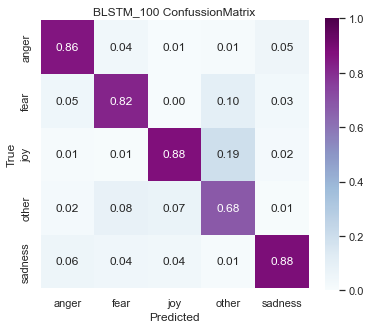

60/60 [==============================] - 1s 4ms/step
              precision    recall  f1-score      support
anger          0.858333  0.777358  0.815842   265.000000
fear           0.740000  0.860465  0.795699   215.000000
joy            0.913313  0.880597  0.896657   670.000000
other          0.656250  0.677419  0.666667   217.000000
sadness        0.905357  0.916817  0.911051   553.000000
accuracy       0.851562  0.851562  0.851562     0.851562
macro avg      0.814651  0.822531  0.817183  1920.000000
weighted avg   0.854972  0.851562  0.852350  1920.000000


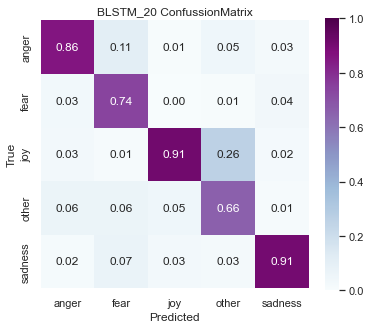

In [7]:
ModelReportAndCMatrix(BLSTM_100_MODEL,ednlp,sequenceLengthLong)
ModelReportAndCMatrix(BLSTM_20_MODEL,ednlp,sequenceLengthShort)

63/63 [==============================] - 0s 6ms/step
              precision    recall  f1-score    support
anger          0.887273  0.887273  0.887273   275.0000
fear           0.807377  0.879464  0.841880   224.0000
joy            0.928152  0.910791  0.919390   695.0000
other          0.685259  0.764444  0.722689   225.0000
sadness        0.932482  0.879518  0.905226   581.0000
accuracy       0.878500  0.878500  0.878500     0.8785
macro avg      0.848109  0.864298  0.855292  2000.0000
weighted avg   0.882937  0.878500  0.880049  2000.0000


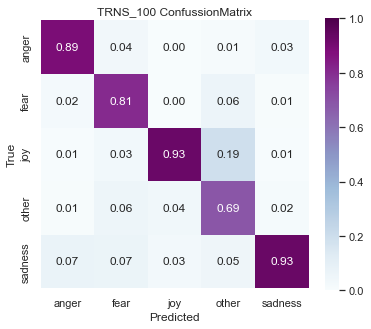

60/60 [==============================] - 0s 4ms/step
              precision    recall  f1-score      support
anger          0.887597  0.864151  0.875717   265.000000
fear           0.817352  0.832558  0.824885   215.000000
joy            0.923313  0.898507  0.910741   670.000000
other          0.676000  0.778802  0.723769   217.000000
sadness        0.920518  0.900542  0.910420   553.000000
accuracy       0.873437  0.873437  0.873437     0.873437
macro avg      0.844956  0.854912  0.849106  1920.000000
weighted avg   0.877761  0.873437  0.875069  1920.000000


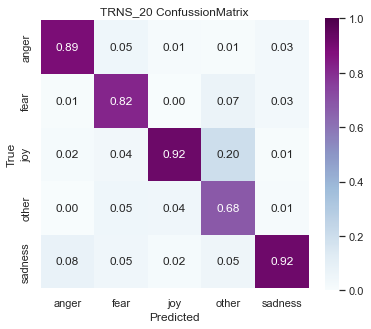

In [8]:
ModelReportAndCMatrix(TRNS_100_Model,ednlp,sequenceLengthLong)
ModelReportAndCMatrix(TRNS_20_Model,ednlp,sequenceLengthShort)

 # Live Tests
 Test the models in real time.

In [9]:
testText = input("Please input a string to predict:")
print(predictText(BLSTM_100_MODEL, testText, tokenizer, sequenceLengthLong))

Model: BLSTM_100
Text: what an awful day it is today
Prediction: sadness


In [10]:
testText = input("Please input a string to predict:")
print(predictText(TRNS_100_Model, testText, tokenizer, sequenceLengthLong))

Model: TRNS_100
Text: we're going to have a wonderful day today
Prediction: joy


 That was fun wasn't it?
 # :)